# Survival Analysis on Echocardiogam heart attack data 

This analysis performs survival analysis to predict survival month ("survival") base on the covariates in Echocardiogram - UCI data. The survival analysis includes use of censoring data, Kaplan-Meier estimates, Log-rank test, and Cox proportional hazards model. There is little correlation between survival time and the covariates, which makes it hard to derive significant results. However, by exploring Kaplan-Meier estimates, it seems to have difference in survival time in the first two years after heart attacks.

# Packages used

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from sklearn.impute import SimpleImputer
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from scipy import stats

When I installed lifelines package, it cuased errors. I'm using Windows PC. I downloaded Visual Sutudio C++ Tool Box and run "pip install lifelines" at Anaconda Prompt to solve this problem. I also copied and pasted error messages in Google to solve it.

# Data 

In [2]:
df = pd.read_csv("../input/echocardiogram.csv")
df.head()

,survival,alive,age,pericardialeffusion,fractionalshortening,epss,lvdd,wallmotion-score,wallmotion-index,mult,name,group,aliveat1
0,11.0,0.0,71.0,0.0,0.260,9.000,4.600,14.0,1.00,1.000,name,1,0.0
1,19.0,0.0,72.0,0.0,0.380,6.000,4.100,14.0,1.70,0.588,name,1,0.0
2,16.0,0.0,55.0,0.0,0.260,4.000,3.420,14.0,1.00,1.000,name,1,0.0
3,57.0,0.0,60.0,0.0,0.253,12.062,4.603,16.0,1.45,0.788,name,1,0.0
4,19.0,1.0,57.0,0.0,0.160,22.000,5.750,18.0,2.25,0.571,name,1,0.0


# Check missing values 

In [3]:
print(df.isnull().sum())
print(df.shape)

survival                 3
alive                    2
age                      7
pericardialeffusion      1
fractionalshortening     9
epss                    16
lvdd                    12
wallmotion-score         5
wallmotion-index         3
mult                     4
name                     2
group                   23
aliveat1                58
dtype: int64
(133, 13)


We only have 133 observations, but there are many missing values across variables. Since I don't wanna drop these data, I'm gonna implement imputation for missing values with means of each columns.

# Impute missing values with mean

In [4]:
imp_mean = SimpleImputer(missing_values = np.nan, strategy = 'mean')
COLUMNS = ['age', 'pericardialeffusion', 'fractionalshortening', 'epss', 'lvdd', 'wallmotion-score']
X = imp_mean.fit_transform(df[COLUMNS])
df_X = pd.DataFrame(X,
                    columns = COLUMNS)
df_X.shape

(133, 6)

In [5]:
COLUMNS_keep = ['survival', 'alive']
df_keep = df[COLUMNS_keep]
df_keep.shape

(133, 2)

In [6]:
df = pd.concat([df_keep, df_X], axis = 1)
df = df.dropna() 
print(df.isnull().sum())
print(df.shape)

survival                0
alive                   0
age                     0
pericardialeffusion     0
fractionalshortening    0
epss                    0
lvdd                    0
wallmotion-score        0
dtype: int64
(130, 8)


dropna function applies to survival and alive variables which I don't consider imputation for. The number of the data for analysis is 130 observations.

# Scatter plots between survival and covariates

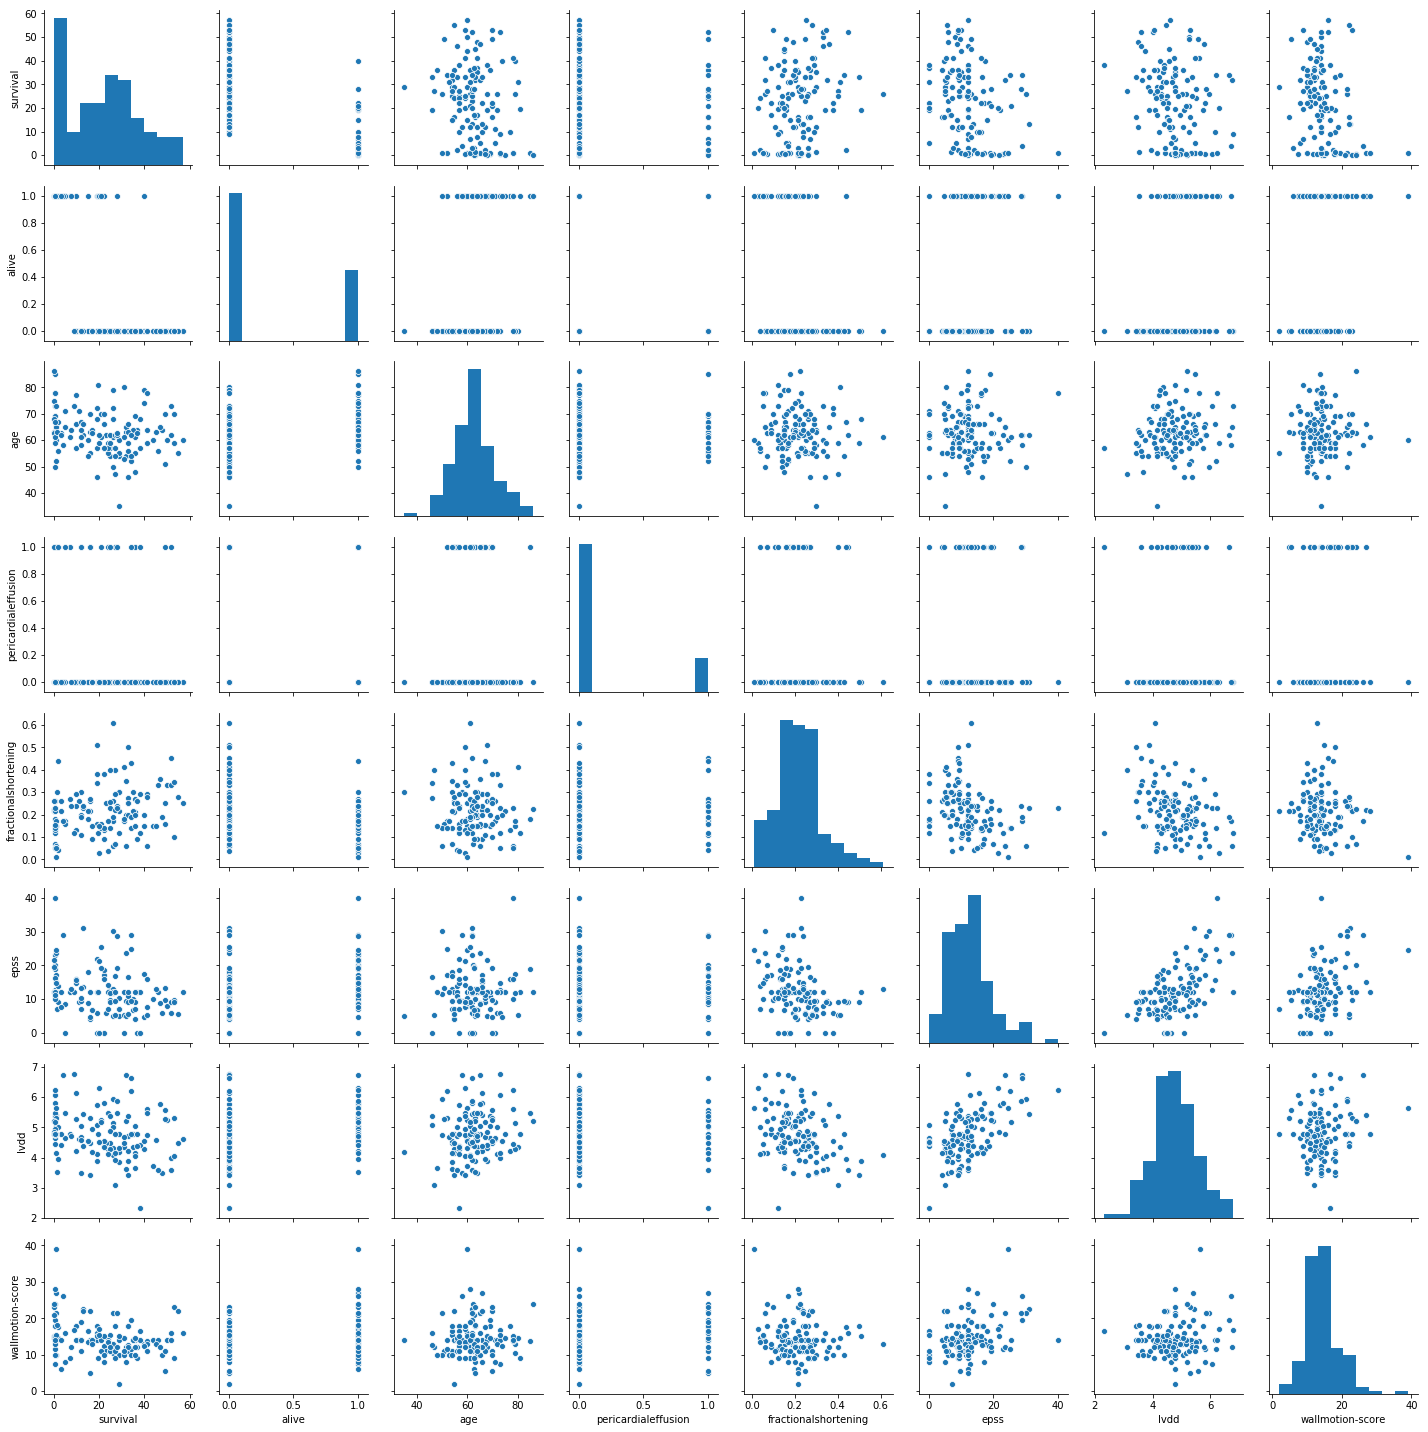

In [7]:
sns.pairplot(df)

# Check censored data 

For alive = 1 patients, because they are alive during data collection period and we do not know their survival months after the data collection, they are regarded as censored data. Hence, the following analysis needs to consider the censored data by making dead variable below.

In [8]:
df.loc[df.alive == 1, 'dead'] = 0
df.loc[df.alive == 0, 'dead'] = 1
df.groupby('dead').count()

,survival,alive,age,pericardialeffusion,fractionalshortening,epss,lvdd,wallmotion-score
dead,,,,,,,,
0.0,42,42,42,42,42,42,42,42
1.0,88,88,88,88,88,88,88,88


We have 88 non-censored data and 42 censored data.

# Kaplan Meier estimates

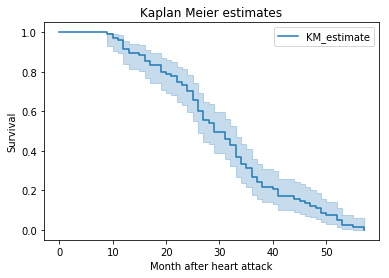

In [9]:
kmf = KaplanMeierFitter()
T = df['survival']
E = df['dead']
kmf.fit(T, event_observed = E)
kmf.plot()
plt.title("Kaplan Meier estimates")
plt.xlabel("Month after heart attack")
plt.ylabel("Survival")
plt.show()

I saw a slightly negative relationship of age and wallmotion-score to survival, so I used median to make two groups within each variable to see difference in survival time.

In [10]:
print(statistics.median(df['age']))
print(statistics.median(df['wallmotion-score']))

62.2645
14.0


Text(0, 0.5, 'Survival')

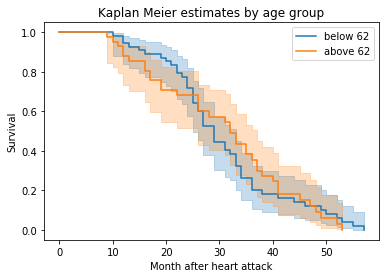

In [11]:
age_group = df['age'] < statistics.median(df['age'])
ax = plt.subplot(111)
kmf.fit(T[age_group], event_observed = E[age_group], label = 'below 62')
kmf.plot(ax = ax)
kmf.fit(T[~age_group], event_observed = E[~age_group], label = 'above 62')
kmf.plot(ax = ax)
plt.title("Kaplan Meier estimates by age group")
plt.xlabel("Month after heart attack")
plt.ylabel("Survival")

Text(0, 0.5, 'Survival')

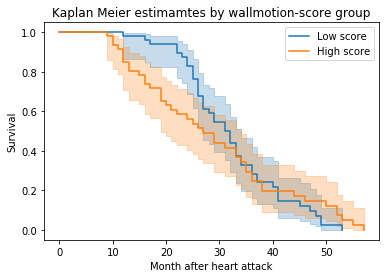

In [12]:
score_group = df['wallmotion-score'] < statistics.median(df['wallmotion-score'])
ax = plt.subplot(111)
kmf.fit(T[score_group], event_observed = E[score_group], label = 'Low score')
kmf.plot(ax = ax)
kmf.fit(T[~score_group], event_observed = E[~score_group], label = 'High score')
kmf.plot(ax = ax)
plt.title("Kaplan Meier estimamtes by wallmotion-score group")
plt.xlabel("Month after heart attack")
plt.ylabel("Survival")

The difference by age groups seems to be weak. However, there seems to differ by wallmotion-score group for the first 24 months (2 years) after heart attack. So I applied the following analysis based on wallmotion-score group.

# Log-rank test

In [13]:
month_cut = 24
df.loc[(df.dead == 1) & (df.survival <= month_cut), 'censored'] = 1
df.loc[(df.dead == 1) & (df.survival > month_cut), 'censored'] = 0
df.loc[df.dead == 0, 'censored'] = 0
E_v2 = df['censored']

T_low = T[score_group]
T_high = T[~score_group]
E_low = E_v2[score_group]
E_high = E_v2[~score_group]

results = logrank_test(T_low, T_high, event_observed_A = E_low, event_observed_B = E_high)
results.print_summary()

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic      p  -log2(p)
          9.98 <0.005      9.31


"test_statistic" here is a chi-square statistic. It shows chi-square statistic 9.98, and p-value is less than 5%. Thus, I confirm that there is a significant difference in suvival time by wallmotion score group for the first 2 year after heart attack.

# Cox proportional hazards model 

In [14]:
cph = CoxPHFitter()
df_score_group = pd.DataFrame(score_group)
df_model = df[['survival', 'censored', 'age']]
df_model = pd.concat([df_model, df_score_group], axis = 1)
cph.fit(df_model, 'survival', 'censored')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 130 observations, 102 censored>
      duration col = 'survival'
         event col = 'censored'
number of subjects = 130
  number of events = 28
    log-likelihood = -117.36
  time fit was run = 2019-05-14 17:29:31 UTC

---
                  coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
age               0.02      1.02      0.02  0.88   0.38      1.39       -0.03        0.07
wallmotion-score -1.27      0.28      0.42 -3.02 <0.005      8.63       -2.09       -0.45
---
Concordance = 0.70
Log-likelihood ratio test = 10.68 on 2 df, -log2(p)=7.71


In [15]:
# p-value of Log-likelihood ratio test
round(stats.chi2.sf(10.68, 2),4)

0.0048

Whether this model is significant or not depends on the result of Log-likelihood ratio test at the bottom of the summary. This statistic follows Chi-square distribution with 2 degree of freedom, and p-value is 0.0048. It says this cox model is significant so that statistical inference is based on this model. Wallmotion-score group is a risk factor for survival time, but age is not by checking p-values. Negative sign of wallmotion-score variable indicates that the patients with low wallmotion score reduce the risk of death. Hazard ration of wallmotion-score is 0.28, which means it reduce in hazard since it is less than 1 and it reduces the hazard by 72% (1 - 0.28). Thus, I conclude that for the first two years after each patient experiences heart attack, the people with high wallmotion score would have a higher risk of death so that we can pay attention to this group of patients.